# Heart attack prediction

I'm working on the Heart Attack dataset. In this notebook we would like to preprocess data, train, evaluate and compare two models: logistic regression and XGBoost.

Short description of variables:
* `age`: The person's age in years
* `sex`: The person's sex
  * 1: male
  * 0: female
* `cp`: chest pain type
  * 0: asymptomatic
  * 1: atypical angina
  * 2: non-anginal pain
  * 3: typical angina
* `trtbps`: The person's resting blood pressure (mm Hg on admission to the hospital)
* `chol`: The person's cholesterol measurement in mg/dl
* `fbs`: The person's fasting blood sugar (> 120 mg/dl)
  * 1: true
  * 0: false
* `restecg`: Resting electrocardiographic measurement
  * 0: showing probable or definite left ventricular hypertrophy by Estes' criteria
  * 1: normal
  * 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
* `thalachh`: The person's maximum heart rate achieved
* `exng`: Exercise induced angina
  * 1: true
  * 0: false
* `oldpeak`: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot.)
* `slp`: the slope of the peak exercise ST segment
  * 0: downsloping
  * 1: flat
  * 2: upsloping
* `caa`: The number of major vessels (0-3) colored by fluoroscopy
* `thall`: Results of the blood flow observed via the radioactive dye
  * 0: NULL (dropped from the dataset previously)
  * 1: fixed defect (no blood flow in some part of the heart)
  * 2: normal blood flow
  * 3: reversible defect (a blood flow is observed but it is not normal)
* `output`: Heart disease (target)
  * 0: disease
  * 1: no disease

## Importing packages

In [43]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix,\
  ConfusionMatrixDisplay, f1_score, recall_score, precision_score,\
  RocCurveDisplay
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

SEED = 42

## Loading data

In [2]:
!gdown 14RnHkHVRmZHdXF7_THt7arQzlzplKbF1

Downloading...
From: https://drive.google.com/uc?id=14RnHkHVRmZHdXF7_THt7arQzlzplKbF1
To: /content/heart.csv
100% 11.3k/11.3k [00:00<00:00, 16.1MB/s]


In [3]:
df_raw = pd.read_csv('heart.csv')
df_raw.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Data preprocessing and analysis

In [4]:
df_raw.info() # only int and float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
print(df_raw.shape) # 303 observations, 14 variables (including one output class)
df_raw.describe()

(303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Based on the data and documentation from kaggle we should apply one-hot encoding transformation to the following variables: `cp`, `restecg`, `slp` and `thall`.

In [9]:
df = pd.get_dummies(df_raw, columns=['cp', 'restecg', 'slp', 'thall'])
df.head()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,caa,output,...,restecg_0,restecg_1,restecg_2,slp_0,slp_1,slp_2,thall_0,thall_1,thall_2,thall_3
0,63,1,145,233,1,150,0,2.3,0,1,...,1,0,0,1,0,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,1,...,0,1,0,1,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,1,...,1,0,0,0,0,1,0,0,1,0
3,56,1,120,236,0,178,0,0.8,0,1,...,0,1,0,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,...,0,1,0,0,0,1,0,0,1,0


In [10]:
df.isnull().values.any() # no missing values

False

In [11]:
np.unique(df.output, return_counts=True) # quite balanced set

(array([0, 1]), array([138, 165]))

In [12]:
X = df.drop('output', axis=1)
y = df.output

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

With stratify argument we can assure than the proportion of values in the sample produced will be the same as the proportion of values in `y`.

Also, I decided to standardize features by removing the mean and scaling to unit variance. We don't want a feature that has a variance that is orders of magnitude larger than others.

For now I will use just train/test split, in the future I can extend it with train/val/test split if needed.

## Logistic regression

In [14]:
LR_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=SEED).fit(X_train, y_train)

In [49]:
list(zip(X.columns.values, LR_model.coef_.squeeze())) # coefficients

[('age', 0.04098663698015276),
 ('sex', -0.6060346701338712),
 ('trtbps', -0.1571146921540503),
 ('chol', -0.5769568040070642),
 ('fbs', -0.06656047733258356),
 ('thalachh', 0.35852588570738986),
 ('exng', -0.387788061295911),
 ('oldpeak', -0.4417289132231543),
 ('caa', -0.5413034871718694),
 ('cp_0', -0.5401076915766784),
 ('cp_1', 0.05439510756428576),
 ('cp_2', 0.410426793008956),
 ('cp_3', 0.25896593533156975),
 ('restecg_0', -0.11704887522488677),
 ('restecg_1', 0.14065904983963828),
 ('restecg_2', -0.09318962554356398),
 ('slp_0', 0.012079913047077152),
 ('slp_1', -0.19670126723322837),
 ('slp_2', 0.1894918952219547),
 ('thall_0', 0.12022884260600852),
 ('thall_1', 0.04626150278285895),
 ('thall_2', 0.3881806894433016),
 ('thall_3', -0.4322376888435946)]

Results look intuitively correct. For instance, variables such as `sex` or `chol` have quite large negative coefficients (although one should take into consideration also std or metrics like p-value to check if these are significant). It means that men are more likely to get heart attack. Also, the higher cholester person has, the chance of heart attack is greater. Quite counter-intuitive is positive coefficient next to the `age` variable, however it could be insignificant.

In [15]:
LR_pred = LR_model.predict(X_test)
LR_pred_prob = LR_model.predict_proba(X_test)[:, 1] # only probs of positive cases
print(f'Acc = {accuracy_score(y_test, LR_pred).round(3)}')
print(f'AUC = {roc_auc_score(y_test, LR_pred_prob).round(3)}')
print(f'F1 = {f1_score(y_test, LR_pred).round(3)}')
print(f'Recall = {recall_score(y_test, LR_pred).round(3)}')
print(f'Precision = {precision_score(y_test, LR_pred).round(3)}')

Acc = 0.77
AUC = 0.872
F1 = 0.794
Recall = 0.818
Precision = 0.771


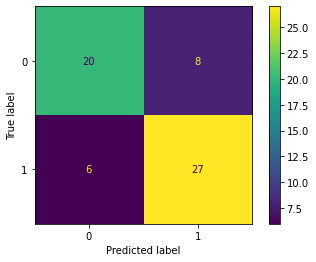

In [44]:
cm = confusion_matrix(y_test, LR_pred, labels=LR_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR_model.classes_)
disp.plot()

This model makes mistakes in both types of errors - recall and prediction are similar. 

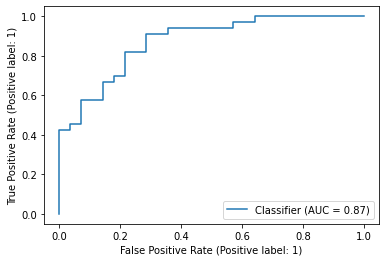

In [46]:
RocCurveDisplay.from_predictions(y_test, LR_pred_prob)

## XGBoost

In [47]:
BST_model = xgb.XGBClassifier(random_state=SEED).fit(X_train, y_train)

Coefficients are not defined for some base learner types such as tree learners

In [48]:
BST_pred = BST_model.predict(X_test)
BST_pred_prob = BST_model.predict_proba(X_test)[:, 1] # only probs of positive cases
print(f'Acc = {accuracy_score(y_test, BST_pred).mean().round(3)}')
print(f'AUC = {roc_auc_score(y_test, BST_pred_prob).round(3)}')
print(f'F1 = {f1_score(y_test, BST_pred).round(3)}')
print(f'Recall = {recall_score(y_test, BST_pred).round(3)}')
print(f'Precision = {precision_score(y_test, BST_pred).round(3)}')

Acc = 0.82
AUC = 0.865
F1 = 0.845
Recall = 0.909
Precision = 0.789


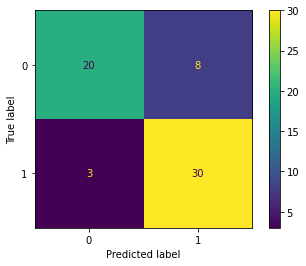

In [52]:
cm = confusion_matrix(y_test, BST_pred, labels=BST_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=BST_model.classes_)
disp.plot()

This model produces less often falsely predict disease (0). It still makes lots of mistakes when falsely predicting no disease (1) - this is serious problem in medical domain.

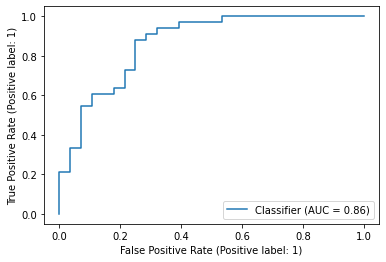

In [51]:
RocCurveDisplay.from_predictions(y_test, BST_pred_prob)

To sum up, performance of these two methods is comparable. Even though accuracy is significantly higher in XGBoost model, the AUC is not. Based on this fact and ROCurve plots it would be difficult to choose better model.